<a href="https://colab.research.google.com/github/17092003vamsi/VAMSI/blob/main/meta_learner_LR_KSR_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

KNN Test Accuracy: 0.8128
Random Forest Test Accuracy: 0.9305
SVM Test Accuracy: 0.9626
Meta-Learner Test Accuracy: 0.9626

Meta-Learner Classification Report:
              precision    recall  f1-score   support

           A       1.00      1.00      1.00        36
         A-S       1.00      0.97      0.99        35
           G       0.88      1.00      0.93        43
         G-S       1.00      1.00      1.00        23
         HPM       0.95      0.90      0.93        21
       HPM-S       1.00      0.86      0.93        29

    accuracy                           0.96       187
   macro avg       0.97      0.96      0.96       187
weighted avg       0.97      0.96      0.96       187



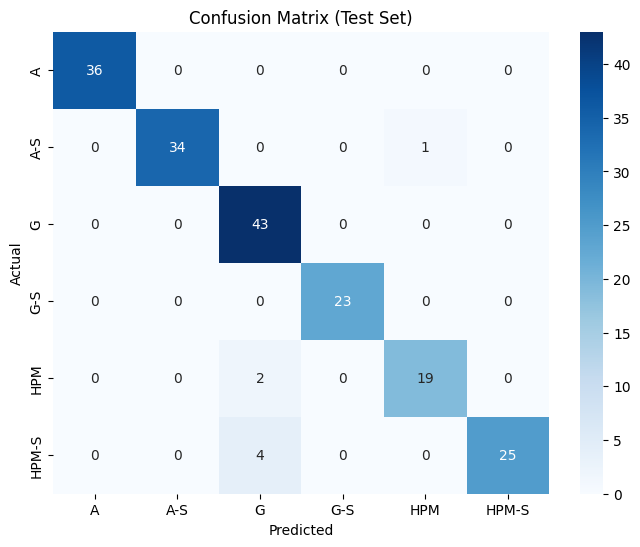

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
file_path = 'project 2 sap.csv'
data = pd.read_csv(file_path)

# Preprocessing
label_encoder = LabelEncoder()
data['Lable'] = label_encoder.fit_transform(data['Lable'])  # Encode target labels
y = data['Lable']
X = data.drop(columns=['Type', 'Lable'])

# Handle missing values and scale features
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Base models
knn_model = KNeighborsClassifier(n_neighbors=5)
rf_model = RandomForestClassifier(random_state=42)
svm_model = SVC(kernel='linear', probability=True)

# Train base models
knn_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)
svm_model.fit(X_train, y_train)

# Predictions on validation set for stacking
knn_val_preds = knn_model.predict_proba(X_val)
rf_val_preds = rf_model.predict_proba(X_val)
svm_val_preds = svm_model.predict_proba(X_val)

# Stack predictions for meta-learner
meta_X_val = np.hstack((knn_val_preds, rf_val_preds, svm_val_preds))

# Meta-learner: Logistic Regression
meta_learner = LogisticRegression()
meta_learner.fit(meta_X_val, y_val)

# Predictions on test set
knn_test_preds = knn_model.predict(X_test)
rf_test_preds = rf_model.predict(X_test)
svm_test_preds = svm_model.predict(X_test)

# Test accuracies for base models
knn_accuracy = accuracy_score(y_test, knn_test_preds)
rf_accuracy = accuracy_score(y_test, rf_test_preds)
svm_accuracy = accuracy_score(y_test, svm_test_preds)

# Meta-learner evaluation
knn_test_proba = knn_model.predict_proba(X_test)
rf_test_proba = rf_model.predict_proba(X_test)
svm_test_proba = svm_model.predict_proba(X_test)

meta_X_test = np.hstack((knn_test_proba, rf_test_proba, svm_test_proba))
meta_test_preds = meta_learner.predict(meta_X_test)
meta_accuracy = accuracy_score(y_test, meta_test_preds)

# Print all accuracies
print(f"KNN Test Accuracy: {knn_accuracy:.4f}")
print(f"Random Forest Test Accuracy: {rf_accuracy:.4f}")
print(f"SVM Test Accuracy: {svm_accuracy:.4f}")
print(f"Meta-Learner Test Accuracy: {meta_accuracy:.4f}")

# Classification report and confusion matrix for the ensemble
print("\nMeta-Learner Classification Report:")
print(classification_report(y_test, meta_test_preds, target_names=label_encoder.classes_))

conf_matrix = confusion_matrix(y_test, meta_test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
